In [1]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from statsmodels.tsa.stattools import acf, pacf

from math import sqrt, log, exp
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_log_error as msle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

import catboost as cb

In [2]:
# Importing the data
data = pd.read_csv('../input/beijing-air-quality-preprocessed/airquality_data.csv')

# Train test split

In [3]:
data.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,9.80000,800.0,88.0,0.1,1021.1,-18.6,0.0,7,4.4,5
1,2,2013,3,1,1,6.0,15.0,5.0,11.00000,800.0,88.0,-0.3,1021.5,-19.0,0.0,7,4.0,5
2,3,2013,3,1,2,5.0,18.0,5.2,10.09936,700.0,52.0,-0.7,1021.5,-19.8,0.0,14,4.6,5
3,4,2013,3,1,3,6.0,20.0,6.0,13.60000,320.0,49.8,-1.0,1022.7,-21.2,0.0,13,2.8,5
4,5,2013,3,1,4,5.0,17.0,5.0,15.60000,600.0,73.0,-1.3,1023.0,-21.4,0.0,14,3.6,5


In [4]:
# Splitting tha data into train and test
train_data, test = train_test_split(data,
                               test_size=0.1,
                               shuffle=False)

In [5]:
# Splitting tha data into train and valid
train, valid = train_test_split(train_data,
                               test_size=0.1,
                               shuffle=False)

# Feature Engineering

# PACF
This function was introduced as part of the Box–Jenkins approach to time series modelling, whereby plotting the partial autocorrelative functions one could determine the appropriate lags **p** in an AR **(p)** model or in an extended ARIMA **(p,d,q)** model.

We choose for example the explanatory variable `PM10` and how it is correlated in time.

We noticed that all variable verify the same plot meaning the best lag is two.

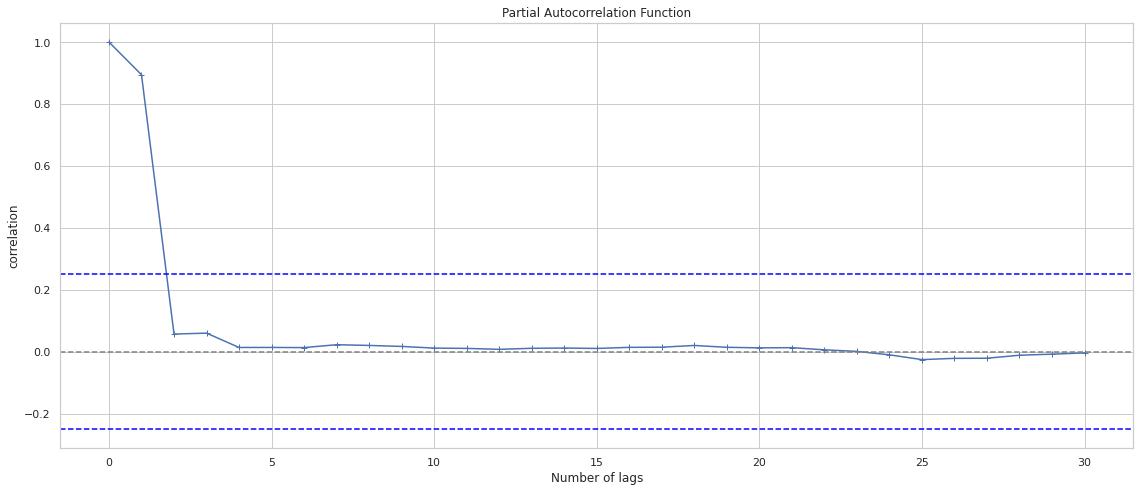

In [6]:
# The variable we choose to apply pacf

y = train['PM10']

#calling partial correlation function
lag_pacf = pacf(y, nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 7))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y= -((np.std(y) * 1.96)) / np.sqrt(len(y)), linestyle='--',color='blue') # lower bound
plt.axhline(y= ((np.std(y) * 1.96)) / np.sqrt(len(y)),linestyle='--',color='blue') # Upper bound
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.tight_layout()

In [7]:
def series_to_supervised(data_df, lag=2):
    
    '''Create lagged features'''
    
    # We create the lag features with the pandas function shift
    lag_df = data_df[[col for col in data_df.columns if col not in ['No', 'year', 'month', 'day', 'hour']]].shift(lag)
    lag_df.columns = [col+"_"+f"lag_{lag}" for col in lag_df.columns]
    
    return lag_df

def rolling_window(data_df, window=1):
    
    # We create the rolling mean features (MA) with the pandas function shift
    rolling_df = data_df[[col for col in data_df.columns if col not in ['No','station', 'wd', 'year', 'month', 'day', 'hour', 'PM2.5']]].rolling(window).mean()
    
    # We rename the columùns by adding rolling_{window} at the end
    rolling_df.columns = [col+"_"+f"rolling_{window}" for col in rolling_df.columns]
    
    return rolling_df

In [8]:
# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train, lag=1)
train_lag2 = series_to_supervised(train, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train, window=2)

# Concat everything together
train = pd.concat([train, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train['cum_wspm'] = train['WSPM'].cumsum()

# Saturated vapor pressure
train['saturated_vapor_pressure'] = 6.11*10*((7.5*train['TEMP'])/(237.3+train['TEMP']))
# Actual vapor pressure
train['actual_vapor_pressure'] = 6.11*10*((7.5*train['DEWP'])/(237.3+train['DEWP']))

# Lag features by shift(1) and shift(2)
valid_lag1 = series_to_supervised(valid, lag=1)
valid_lag2 = series_to_supervised(valid, lag=2)

# Rolling window by 2
valid_rolling2 = rolling_window(valid, window=2)

# Concat everything together
valid = pd.concat([valid, valid_lag1, valid_lag2, valid_rolling2], axis=1).dropna()

# Cumulative wind speed
valid['cum_wspm'] = valid['WSPM'].cumsum()

# Saturated vapor pressure
valid['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['TEMP']) / (237.3 + valid['TEMP']))
# Actual vapor pressure
valid['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * valid['DEWP']) / (237.3 + valid['DEWP']))


# Lag features by shift(1) and shift(2)
test_lag1 = series_to_supervised(test, lag=1)
test_lag2 = series_to_supervised(test, lag=2)

# Rolling window by 2
test_rolling2 = rolling_window(test, window=2)

# Concat everything together
test = pd.concat([test, test_lag1, test_lag2, test_rolling2], axis=1).dropna()

# Cumulative wind speed
test['cum_wspm'] = test['WSPM'].cumsum()

# Saturated vapor pressure
test['saturated_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['TEMP']) / (237.3 + test['TEMP']))
# Actual vapor pressure
test['actual_vapor_pressure'] = 6.11 * 10 * ((7.5 * test['DEWP']) / (237.3 + test['DEWP']))

# endogenous variables
features_columns = [col for col in train.columns if col not in ['No', 'PM2.5']]

del train_lag1, train_lag2, train_rolling2
del valid_lag1, valid_lag2, valid_rolling2
del test_lag1, test_lag2, test_rolling2

_ = gc.collect()

In [9]:
# Transform the data into pool format for CatBoost
train_pool = cb.Pool(train[features_columns], np.log(train["PM2.5"]), cat_features=['wd', 'station'])
val_pool = cb.Pool(valid[features_columns], np.log(valid["PM2.5"]), cat_features=['wd', 'station'])
test_pool = cb.Pool(test[features_columns], cat_features=['wd', 'station'])

# Fit and train catboost
CATBOOST_PARAMS = {"loss_function": "RMSE",
                   "objective":"RMSE",
                   "iterations": 20000,
                   "learning_rate": 0.01,
                   "max_bin":100,
                   "depth": 5,
                   #"colsample_bylevel":0.7,
                   "task_type":'GPU',
                   "random_seed":2022,
             }
# Train model
model = cb.CatBoostRegressor(**CATBOOST_PARAMS)
model.fit(train_pool, eval_set=val_pool, verbose=2500, early_stopping_rounds=50)

# Predictions and score on validation data
pred_val = model.predict(val_pool)
pred_test = model.predict(test_pool)


# Calculate score on validation set
mse_score_valid = mse(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))
mae_score_valid = mae(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))
msle_score_valid = msle(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))
r2_score_valid = r2(y_true=valid["PM2.5"], y_pred=np.exp(pred_val))

# Calculate score on test set
mse_score_test = mse(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
mae_score_test = mae(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
msle_score_test = msle(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
r2_score_test = r2(y_true=test["PM2.5"], y_pred=np.exp(pred_test))
print("\n")

print(f"Catboost rmse valid: {sqrt(mse_score_valid)}")
print(f"Catboost mae valid: {mae_score_valid}")
print(f"Catboost r2 valid{r2_score_valid}")

print('\n')

print(f"Catboost rmse test: {sqrt(mse_score_test)}")
print(f"Catboost mae test:  {mae_score_test}")
print(f"Catboost r2 test: {r2_score_test}")

0:	learn: 1.0707251	test: 1.0326352	best: 1.0326352 (0)	total: 22.7ms	remaining: 7m 34s
2500:	learn: 0.2597029	test: 0.2350437	best: 0.2350437 (2500)	total: 46.6s	remaining: 5m 25s
5000:	learn: 0.2515383	test: 0.2304183	best: 0.2304040 (4997)	total: 1m 34s	remaining: 4m 42s
7500:	learn: 0.2466663	test: 0.2282287	best: 0.2282287 (7500)	total: 2m 21s	remaining: 3m 55s
bestTest = 0.2273587553
bestIteration = 8915
Shrink model to first 8916 iterations.


Catboost rmse valid: 10.624370378223933
Catboost mae valid: 6.198144472472129
Catboost r2 valid0.966541917643603


Catboost rmse test: 10.049266701447328
Catboost mae test:  5.9764968122422015
Catboost r2 test: 0.9703972288696459


# Configuration

In [10]:
N_SPLITS = 5
SEED = 42

In [11]:
train_data.shape[0] // (N_SPLITS + 1)

60243

In [12]:
np.ceil(train_data.shape[0]*0.1).astype(int)

36147

# Catboost CV

In [13]:
# Place holders for predictions
oof_catboost = np.zeros((train_data.shape[0]))
oof_target = np.zeros((train_data.shape[0]))

predictions_catboost = np.zeros((test.shape[0]))
counter = 1

# Placer holders for calculating scores
mse_scores_catboost = []
mae_scores_catboost = []
msle_scores_catboost = []
r2_scores_catboost = []

# Lag features by shift(1) and shift(2)
train_lag1 = series_to_supervised(train_data, lag=1)
train_lag2 = series_to_supervised(train_data, lag=2)

# Rolling window by 2
train_rolling2 = rolling_window(train_data, window=2)

# Concat everything together
train_data = pd.concat([train_data, train_lag1, train_lag2, train_rolling2], axis=1).dropna()

# Cumulative wind speed
train_data['cum_wspm'] = train_data['WSPM'].cumsum()

# Saturated vapor pressure
train_data['saturated_vapor_pressure'] = 6.11*10*((7.5*train_data['TEMP'])/(237.3+train_data['TEMP']))
# Actual vapor pressure
train_data['actual_vapor_pressure'] = 6.11*10*((7.5*train_data['DEWP'])/(237.3+train_data['DEWP']))

# Features to use for training and prediction
features_columns = [col for col in train_data.columns if col not in ['No', 'PM2.5']]

# TimeSeriesSplit validation 
tsp = TimeSeriesSplit(n_splits=5, test_size=np.ceil(train_data.shape[0]*0.1).astype(int))



# TimeSeriesSplit validation 
tsp = TimeSeriesSplit(n_splits=5, test_size=np.ceil(train_data.shape[0]*0.1).astype(int))

for trn_idx, vld_idx in tsp.split(train_data):
    
    
    # train valid separation
    print(f"CV {counter}/{N_SPLITS}")
    print('\n')
    train_pool = cb.Pool(train_data.iloc[trn_idx][features_columns], np.log(train_data.iloc[trn_idx]["PM2.5"]), cat_features=['wd', 'station'])
    val_pool = cb.Pool(train_data.iloc[vld_idx][features_columns], np.log(train_data.iloc[vld_idx]["PM2.5"]), cat_features=['wd', 'station'])
    test_pool = cb.Pool(test[features_columns], cat_features=['wd', 'station'])

    
    # Fit and train catboost
    CATBOOST_PARAMS = {"loss_function": "RMSE",
                       "objective":"RMSE",
                       "iterations": 20000,
                       "learning_rate": 0.01,
                       "max_bin":100,
                       "depth": 5,
                       #"colsample_bylevel":0.7,
                       "task_type":'GPU',
                       "random_seed":2022,
             }

    model = cb.CatBoostRegressor(**CATBOOST_PARAMS)
    model.fit(train_pool, eval_set=val_pool, verbose=2500, early_stopping_rounds=50)

    # Predictions and score on validation data
    pred_val = model.predict(val_pool)
    pred_test = model.predict(test_pool)
    
    # Register the score on each fold   
    mse_score_valid = mse(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=np.exp(pred_val))
    mae_score_valid = mae(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=np.exp(pred_val))
    msle_score_valid = msle(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=np.exp(pred_val))
    r2_score_valid = r2(y_true=train_data.iloc[vld_idx]["PM2.5"], y_pred=np.exp(pred_val))
    
    print('\n')
    print(f"Fold {counter} Catboost rmse: {sqrt(mse_score_valid)}")
    print(f"Fold {counter} Catboost  mae: {mae_score_valid}")
    print(f"Fold {counter} Catboost rmse: {sqrt(msle_score_valid)}")
    print(f"Fold {counter} Catboost r2: {r2_score_valid}")
    print('\n')
    
    # Register the score on each fold
    mse_scores_catboost.append(sqrt(mse_score_valid))
    mae_scores_catboost.append(mae_score_valid)
    msle_scores_catboost.append(sqrt(msle_score_valid))
    r2_scores_catboost.append(r2_score_valid)
    
    # Calculate prediction on test set  
    oof_catboost[vld_idx] = pred_val
    oof_target[vld_idx] = train_data.iloc[vld_idx]["PM2.5"]
    predictions_catboost += pred_test / N_SPLITS
    counter += 1

    
# Inference score
mse_score_test = mse(y_true=test["PM2.5"], y_pred=np.exp(predictions_catboost) )
mae_score_test = mae(y_true=test["PM2.5"], y_pred=np.exp(predictions_catboost))
msle_score_test = msle(y_true=test["PM2.5"], y_pred=np.exp(predictions_catboost))
r2_score_test = r2(y_true=test["PM2.5"], y_pred=np.exp(predictions_catboost))

print(f"Catboost rmse cv: {np.array(mse_scores_catboost).mean()}")
print(f"Catboost rmae cv: {np.array(mae_scores_catboost).mean()}")
print(f"Catboost r2 cv: {np.array(r2_scores_catboost).mean()}")

print('\n')

print(f"Catboost rmse test: {sqrt(mse_score_test)}")
print(f"Catboost rmae test: {mae_score_test}")
print(f"Catboost r2 test: {r2_score_test}")

CV 1/5


0:	learn: 1.0476559	test: 1.0714055	best: 1.0714055 (0)	total: 15.7ms	remaining: 5m 13s
2500:	learn: 0.2464177	test: 0.2671744	best: 0.2671744 (2500)	total: 41s	remaining: 4m 47s
5000:	learn: 0.2369127	test: 0.2617766	best: 0.2617766 (5000)	total: 1m 21s	remaining: 4m 3s
bestTest = 0.2598915302
bestIteration = 7091
Shrink model to first 7092 iterations.


Fold 1 Catboost rmse: 10.664241624228454
Fold 1 Catboost  mae: 6.431407397624472
Fold 1 Catboost rmse: 0.23818740642837646
Fold 1 Catboost r2: 0.9671218076049766


CV 2/5


0:	learn: 1.0516163	test: 1.0742676	best: 1.0742676 (0)	total: 16.4ms	remaining: 5m 27s
2500:	learn: 0.2484837	test: 0.2789193	best: 0.2789193 (2500)	total: 41.6s	remaining: 4m 51s
bestTest = 0.276948329
bestIteration = 3836
Shrink model to first 3837 iterations.


Fold 2 Catboost rmse: 10.731070318432195
Fold 2 Catboost  mae: 6.442524276466047
Fold 2 Catboost rmse: 0.25327525483697266
Fold 2 Catboost r2: 0.9646588455316591


CV 3/5


0:	learn: 1.0548349	t

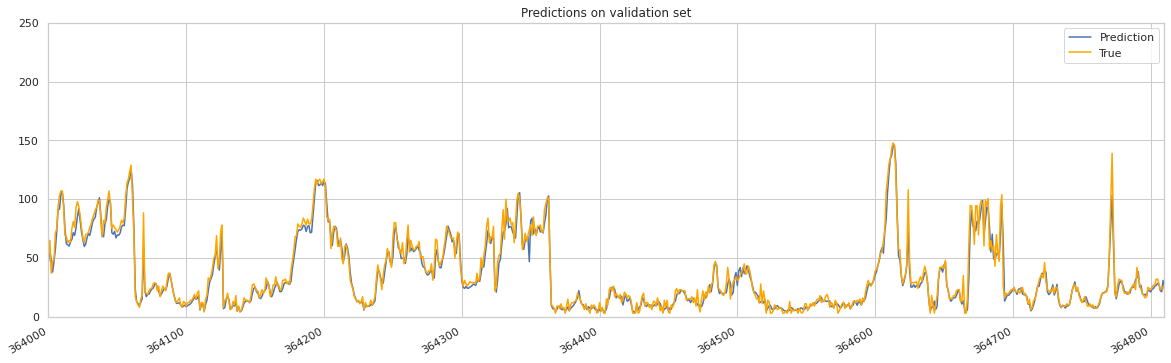

In [14]:
# Create fig size for plotting
fig, ax = plt.subplots(figsize=(20, 6))
# Plot the prediction
ax.plot(test["PM2.5"].index, np.exp(predictions_catboost), color='b', label='Prediction')
# Plot the true values 
ax.plot(test["PM2.5"].index, test["PM2.5"], color='orange', label='True')
# set title
ax.set_title("PM2.5", fontweight="bold", size=16)
# set legend
ax.legend(loc="upper right")


## Rotate date labels automatically
ax.axis([364000, 364810, 0, 250])
fig.autofmt_xdate()
plt.title('Predictions on validation set')
plt.show()